# Introduction


In this file, we estimate the spectral representation based on the El centro earthquake recording.

Refer to the paper below for comparison of the results.

> Liang, J., Chaudhuri, S.R. and Shinozuka, M., 2007. Simulation of nonstationary stochastic processes by spectral representation. Journal of Engineering Mechanics, 133(6), pp.616-627.


**estimate the spectral representation, including:**

- Power spectral density using `Welch`

- EPSD using both `STFT` and `Wavelet Transform`


**what we found out**

- EPSD by `STFT` is 10 times larger than PSD by `Welch` with same *nperseg*

- EPSD by `Wavelet Transform` is even 3 times larger than EPSD by `STFT`

In [31]:
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from dataclasses import dataclass
import os
from StoSpecRep.waveletEPSD import CWTx
from StoSpecRep.utils import SpecBundle, EPSD_show
from StoSpecRep.console import console
from DL_recons_pckg.SpecRepMethod import SRM
from StoSpecRep.utils import save2Vis

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib widget

In [4]:
plt.rcParams.update({
            "text.usetex": True,
            "font.family": "serif",
            })

### load up the data

In [5]:
NS_acc = np.loadtxt('test_data/elcentro_NS.txt')

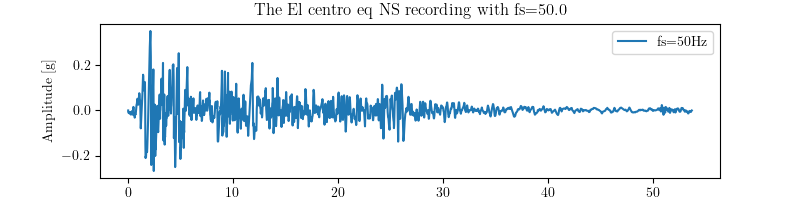

In [6]:
fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(NS_acc[:, 0], NS_acc[:, 1], label='fs=50Hz')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Amplitude [g]')
dt = NS_acc[100, 0] - NS_acc[99, 0]
ax.set_title(f"The El centro eq NS recording with fs={np.ceil(1/dt)}")
ax.legend()
plt.show()

In [7]:
# let's first create a signal object to facilate things

@dataclass
class Targetsignal:
    """ A temporary dataclass that represents the target signal """
    t_axis: float
    signal: float

In [8]:
El_centro = Targetsignal(NS_acc[:, 0], NS_acc[:, 1])

### Global PSD estimate

In [9]:
NPERSEG = 256

f, Pxx = signal.welch(
    El_centro.signal,
    fs=50,
    window='hann',
    nperseg=NPERSEG, 
    scaling='density')

In [10]:
f_periodogram, Pxx_periodogram = signal.welch(
    El_centro.signal,
    fs=50,
    window='hann',
    nperseg=len(El_centro.signal), 
    scaling='density')

The PSD shape is: (129,)


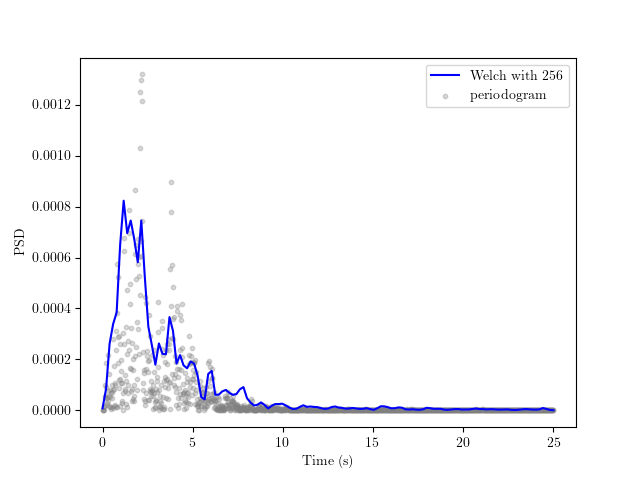

In [11]:
fig, ax = plt.subplots()
ax.plot(f, Pxx, '-b', label=f'Welch with {NPERSEG}')
ax.scatter(f_periodogram, Pxx_periodogram, s=10, color='gray', alpha=0.3, label='periodogram')
ax.set_xlabel('Time (s)')
ax.set_ylabel('PSD')
ax.legend()
print("The PSD shape is:",Pxx.shape)

In [12]:
# plt.close('all')

### Evolutionary EPSD estimate

In [13]:
f, t, Sxx = signal.spectrogram(
                El_centro.signal,
                fs=50,
                nperseg=NPERSEG,
                window='hann',
                mode='psd')

STFT_epsd_El = SpecBundle(epsd=Sxx, freq=f, t_axis=t)

In [14]:
print("The shape of EPSD by STFT:", STFT_epsd_El.epsd.shape)

The shape of EPSD by STFT: (129, 11)


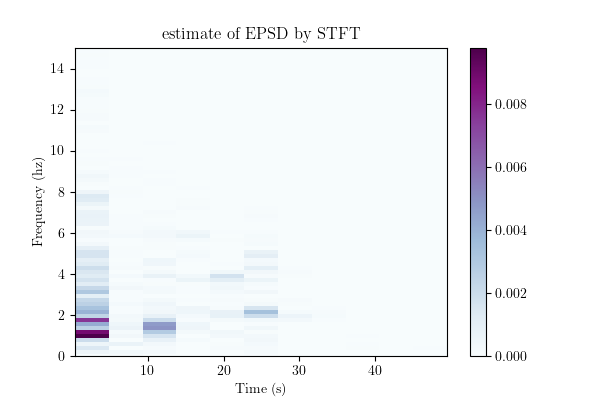

In [15]:
EPSD_show(*STFT_epsd_El, format='2d', title_name='estimate of EPSD by STFT')

Q:
    
- Why STFT spectrogram amplitude is 10 times larger than that of Welch

### EPSD by wavelet transform

In [16]:
Elcentro_obj = CWTx(signal=El_centro.signal, fs=50, t_axis=El_centro.t_axis)

In [17]:
Elcentro_obj.goto_scales

(a=2,b=10) ==> scales_range(4.0, 1024.0) ==> FreqRange(low=0.0396728515625, high=10.15625)

array([   4.        ,    4.8428693 ,    5.86334577,    7.09885432,
          8.59470592,   10.40575936,   12.59843315,   15.2531413 ,
         18.46724244,   22.35861039,   27.06995698,   32.77406593,
         39.68012946,   48.04142024,   58.16457984,   70.42086457,
         85.25976085,  103.22546966,  124.9768646 ,  151.31165532,
        183.19564272,  221.79813868,  268.53484936,  325.11979475,
        393.62816851,  476.57244361,  576.99451455,  698.57725575,
        845.77958706, 1024.        ])

In [18]:
Elcentro_obj.check_scales(a=1, b=8, num=300)

(a=1,b=8) ==> scales_range(2.0, 256.0) ==> FreqRange(low=0.15869140625, high=20.3125)

In [19]:
# propose scales to use
Elcentro_obj.propose_scales(a=1, b=8, num=300)

You've proposed scales:

(a=1,b=8) ==> scales_range(2.0, 256.0) ==> FreqRange(low=0.15869140625, high=20.3125)

In [20]:
# compute EPSD by wavelet transform
Elcentro_obj.computeEPSD()

Computing on the given signal


Yo! Computing EPSD with the proposed scales

Swt shape: (300, 2688)

In [ ]:
''' wavelet EPSD plot'''
# Currently not using this because the plot is too huge ... 
Elcentro_obj.plot_wavelet2dEPSD()
# plt.xlim(10, 15)

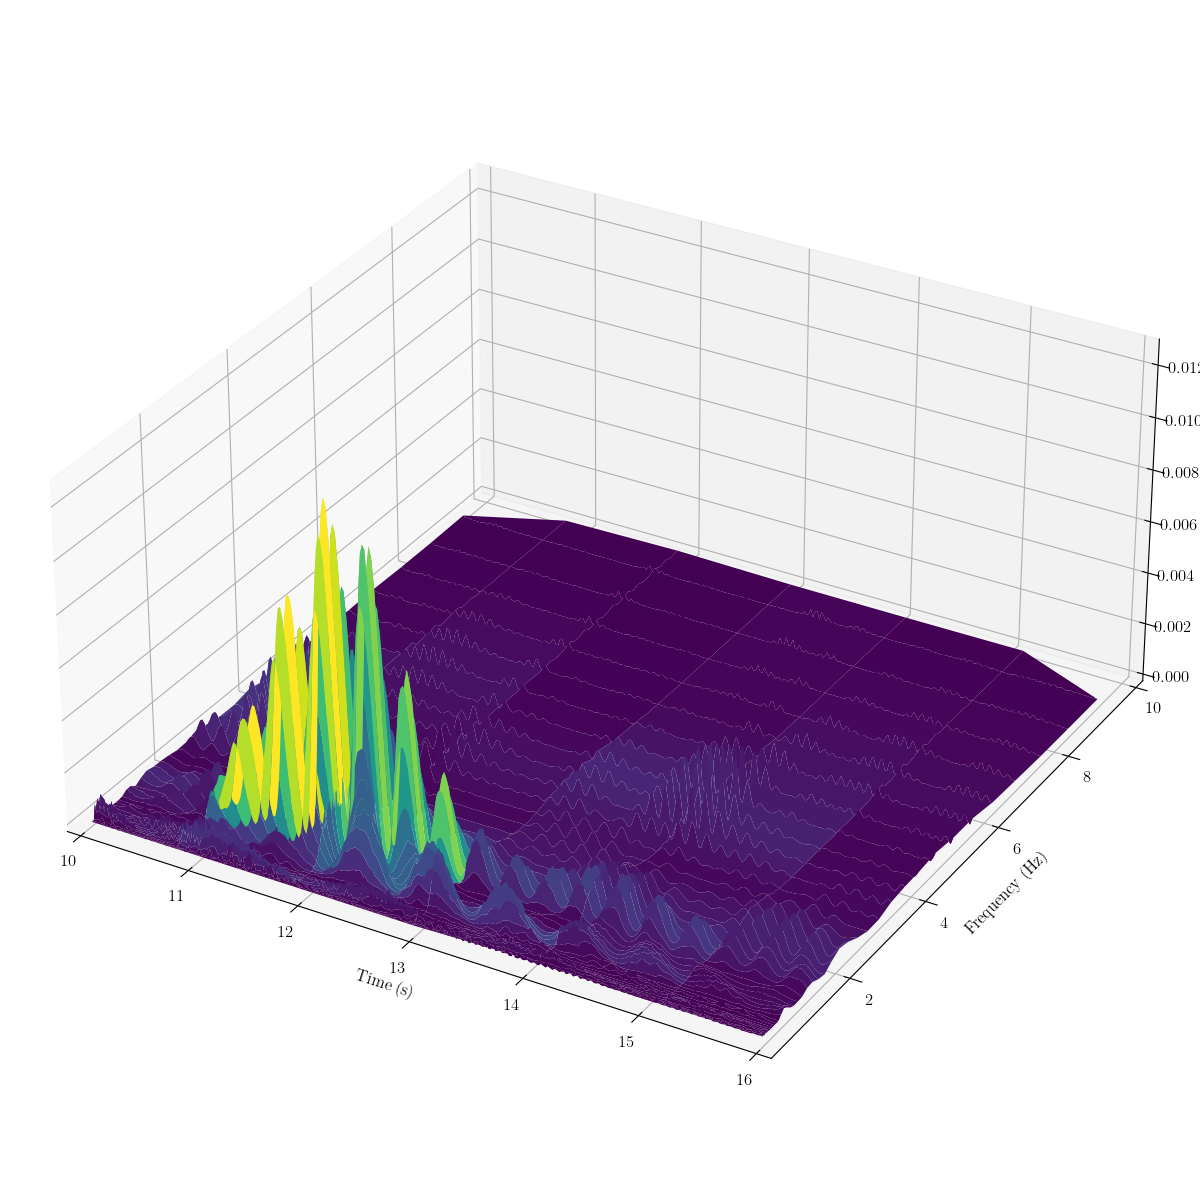

In [32]:
with plt.style.context('default'):
    plt.rcParams.update({
            "font.size": 12,
            "text.usetex": True,
            "font.family": "serif",
            "legend.fontsize": 'small',
            # "figure.figsize" : (20, 5),
            })
    Elcentro_obj.plot_3dEPSD(x_low=10, x_high=16, y_low=0.2, y_high=10)

In [33]:
save2Vis('elcentro_EPSD')

### SRM simulations

#### get a simulation

In [25]:
trial_simulation = Elcentro_obj.g_a_SRMsimu()

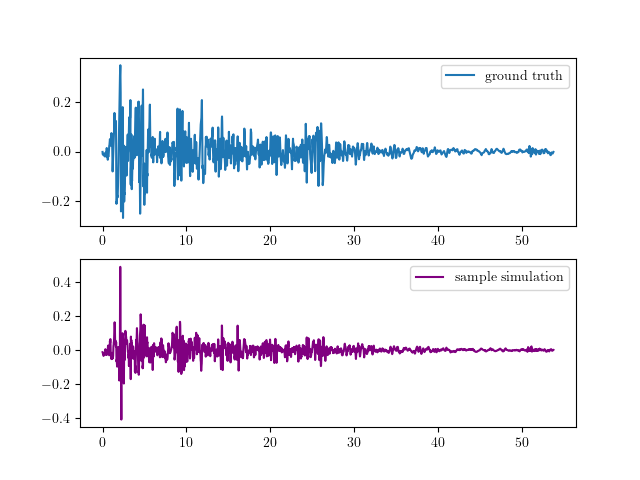

In [26]:
fig, (ax0, ax1) =plt.subplots(nrows=2, ncols=1)

ax0.plot(NS_acc[:, 0], NS_acc[:, 1], label='ground truth')
ax0.legend()
ax1.plot(Elcentro_obj.t_axis, trial_simulation, color='purple', label='sample simulation')
ax1.legend()

#### get an ensemble of simulations

In [27]:
ensemble_simus = Elcentro_obj.g_ensemble_simus(20)

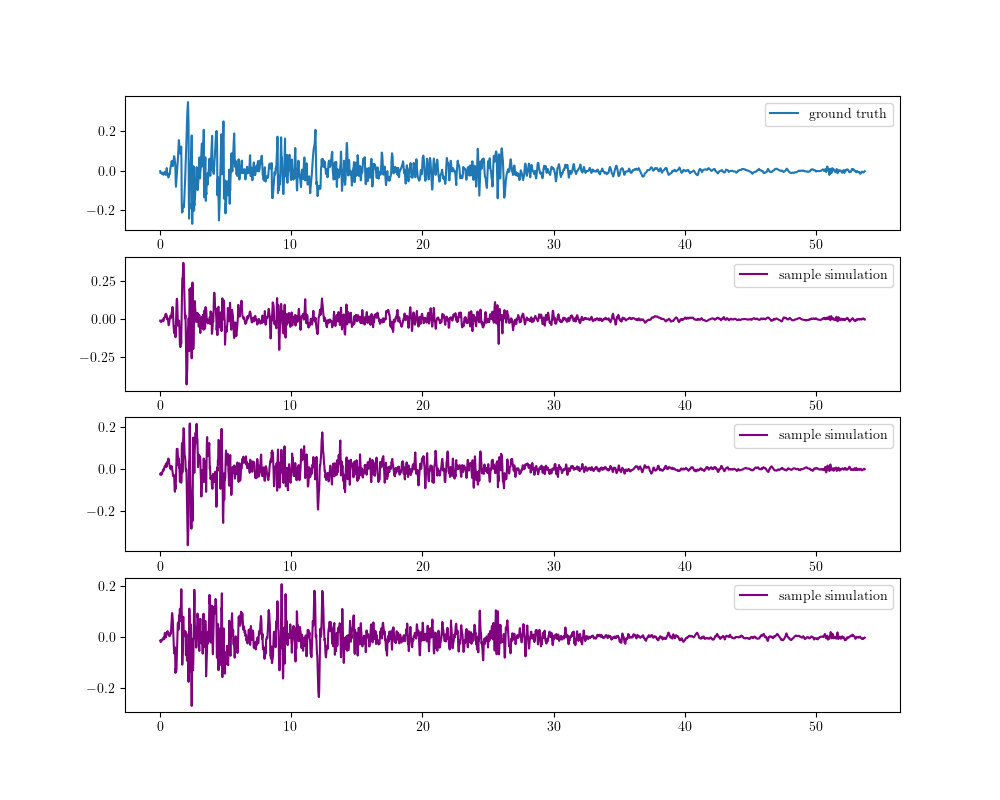

In [29]:
fig, (ax0, ax1, ax2, ax3) =plt.subplots(nrows=4, ncols=1, figsize=(10, 8))

ax0.plot(NS_acc[:, 0], NS_acc[:, 1], label='ground truth')
ax0.legend()

ax1.plot(Elcentro_obj.t_axis, ensemble_simus[0], color='purple', label='sample simulation')
ax1.legend()
ax2.plot(Elcentro_obj.t_axis, ensemble_simus[3], color='purple', label='sample simulation')
ax2.legend()
ax3.plot(Elcentro_obj.t_axis, ensemble_simus[6], color='purple', label='sample simulation')
ax3.legend()
plt.show()